<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab03_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab3 - Linear and Logistic Regression
### Author: Szymon Nowakowski


In [1]:
# Install rpy2 for accessing R libraries in Python
!pip install rpy2

In [2]:

# Import required libraries
import pandas as pd
import numpy as np
from rpy2.robjects import r, pandas2ri

# Activate the pandas-R interface
pandas2ri.activate()

# Load the cpus dataset from the MASS package in R
r('install.packages("MASS", repos="http://cran.us.r-project.org")')
r('library(MASS)')
cpus_r = r('as.data.frame(cpus)')



(as ‘lib’ is unspecified)







	‘/tmp/Rtmpjk1HYL/downloaded_packages’



CPU Dataset Loaded from R:
             name  syct  mmin   mmax  cach  chmin  chmax  perf  estperf
1   ADVISOR 32/60   125   256   6000   256     16    128   198      199
2   AMDAHL 470V/7    29  8000  32000    32      8     32   269      253
3   AMDAHL 470/7A    29  8000  32000    32      8     32   220      253
4  AMDAHL 470V/7B    29  8000  32000    32      8     32   172      253
5  AMDAHL 470V/7C    29  8000  16000    32      8     16   132      132


In [3]:
# Convert the R dataset to a pandas DataFrame
cpus_df = pd.DataFrame(cpus_r)

# Display the dataset
print("CPU Dataset Loaded from R:")
print(cpus_df.head())

# Drop the first and last columns (processor name and estimated performance)
cpus_df = cpus_df.iloc[:, 1:-1]

CPU Dataset Loaded from R:
             name  syct  mmin   mmax  cach  chmin  chmax  perf  estperf
1   ADVISOR 32/60   125   256   6000   256     16    128   198      199
2   AMDAHL 470V/7    29  8000  32000    32      8     32   269      253
3   AMDAHL 470/7A    29  8000  32000    32      8     32   220      253
4  AMDAHL 470V/7B    29  8000  32000    32      8     32   172      253
5  AMDAHL 470V/7C    29  8000  16000    32      8     16   132      132


In [4]:
# Data overview
print("\nDataset summary:")
print(cpus_df.describe())


Dataset summary:
              syct          mmin          mmax        cach       chmin  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            chmax         perf  
count  209.000000   209.000000  
mean    18.267943   105.617225  
std     25.997318   160.830587  
min      0.000000     6.000000  
25%      5.000000    27.000000  
50%      8.000000    50.000000  
75%     24.000000   113.000000  
max    176.000000  1150.000000  


In [5]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Split dataset into predictors and response variable
X = cpus_df.iloc[:, :-1]  # All columns except the last one
y = cpus_df.iloc[:, -1]   # The last column is the response variable

# Split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a linear regression model

model = LinearRegression()
model.fit(X_train, y_train)

# Display coefficients
print("\nModel coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predictions
y_pred = model.predict(X_test)

# Evaluate model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Model coefficients:
syct: 0.0185687855962332
mmin: 0.012670088467355086
mmax: 0.0035221558505683474
cach: 0.7125867924874885
chmin: 3.6518795431475097
chmax: 0.027708662220592206
Intercept: -19.236706185399157

Mean Squared Error (MSE): 14991.786502160634
Root Mean Squared Error (RMSE): 122.4409510832084
R² Score: 0.7381895279320151


# Diagnostic Plots


## Diagnostic Plot Differences: R vs Python

The difference in behavior arises from how **R** and **statsmodels (Python)** handle some diagnostic plotting for regression models.




### R's Behavior:
In **R**, diagnostic plot **"Residuals vs Fitted"** is a model-level diagnostics. It relies on the fitted values ($\hat{y}$) and residuals ($y - \hat{y}$), which are properties of the regression model itself. The plot does not depend on specific predictors.

<img src="https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/residuals_vs_fitted_in_R.PNG?raw=1" alt="residuals vs fitted plot in R" width="600" height="400">


### Python's `sm.graphics.plot_fit`:
In **Python**, the `sm.graphics.plot_fit` function in **statsmodels** is designed specifically to visualize **one predictor variable at a time**. It shows the relationship between the chosen predictor and the fitted values, making it more focused than R's general diagnostic plot.

# How to Get an R-Like "Residuals vs Fitted" Plot in Python

We can emulate R's behavior and plot Residuals vs Fitted independently of specific predictors with a custom plot.

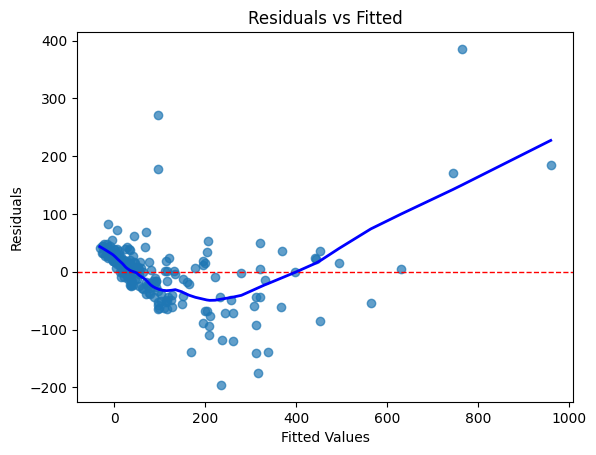

In [15]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Residuals vs Fitted Plot
fitted_values = model.fittedvalues  # Predicted values (fitted values)
residuals = model.resid  # Residuals

# Lowess smoothing for trend line
lowess_smooth = lowess(residuals, fitted_values, frac=0.3)  # frac controls the smoothing

plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(y=0, color="red", linestyle="--", linewidth=1)  # Horizontal line at 0
plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color="blue", linewidth=2, label="Trend Line (Lowess)")

plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()


                            OLS Regression Results                            
Dep. Variable:                   perf   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     215.5
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           6.31e-85
Time:                        13:48:03   Log-Likelihood:                -1148.7
No. Observations:                 209   AIC:                             2311.
Df Residuals:                     202   BIC:                             2335.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -55.9001      8.045     -6.948      0.0

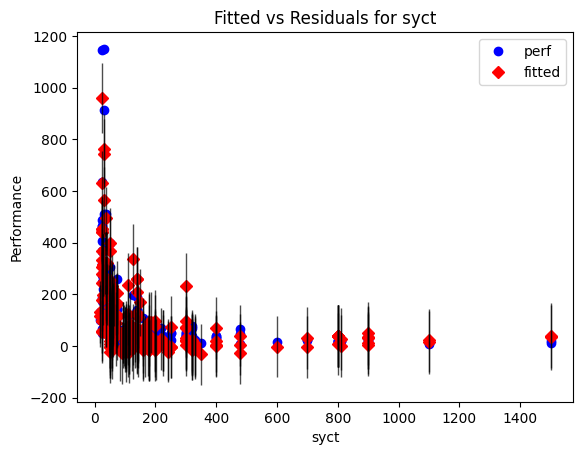

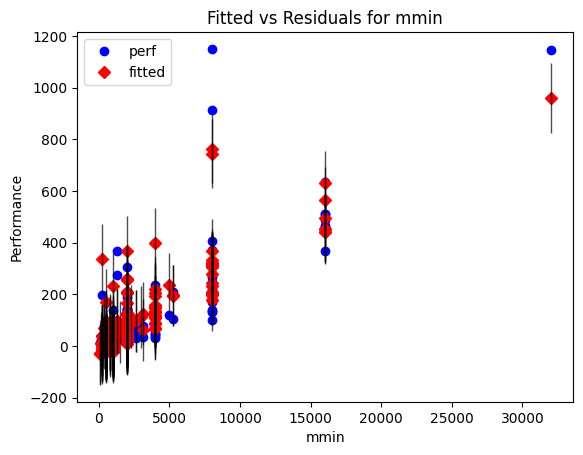

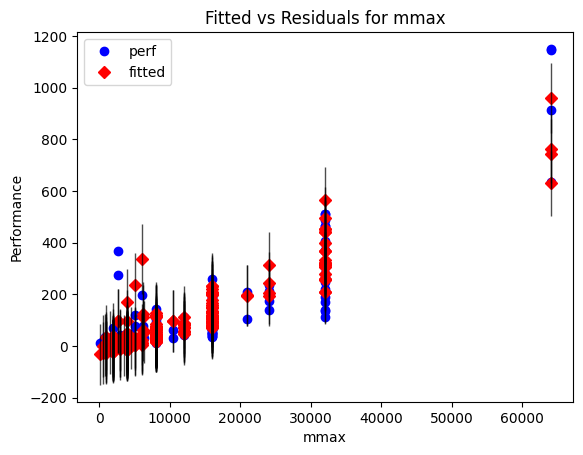

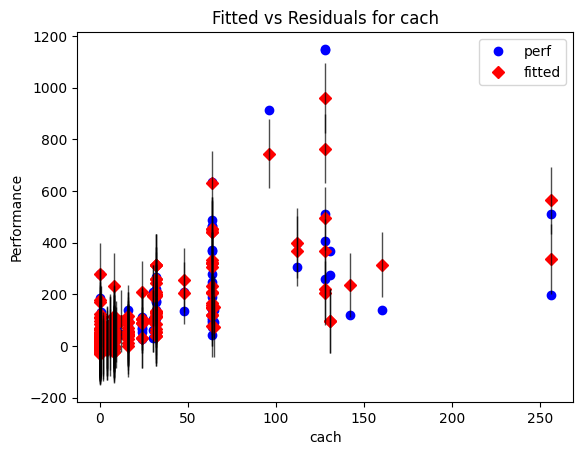

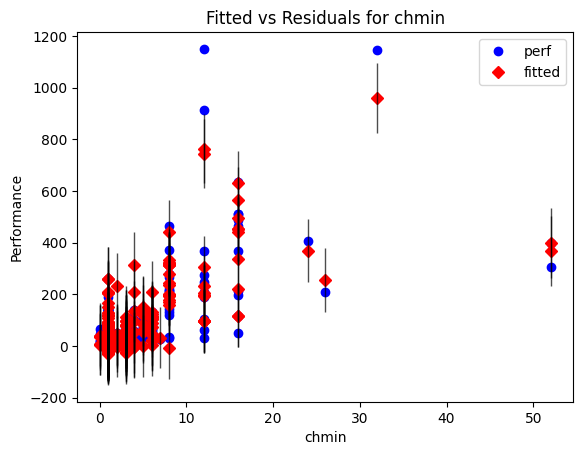

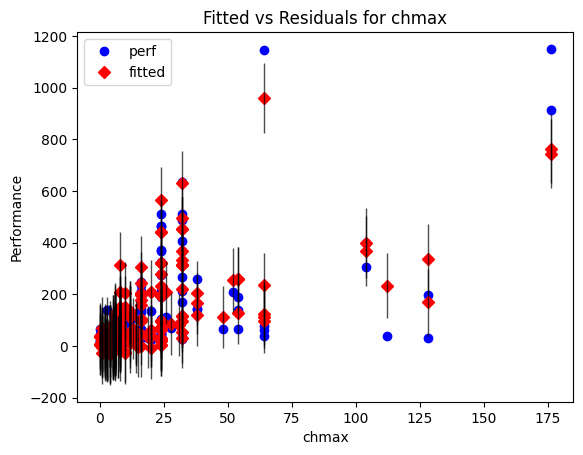

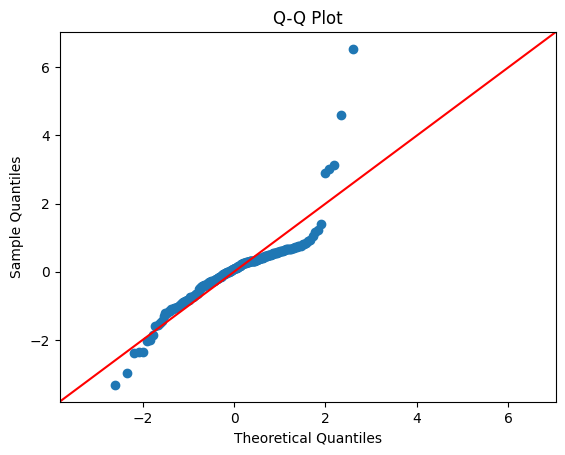

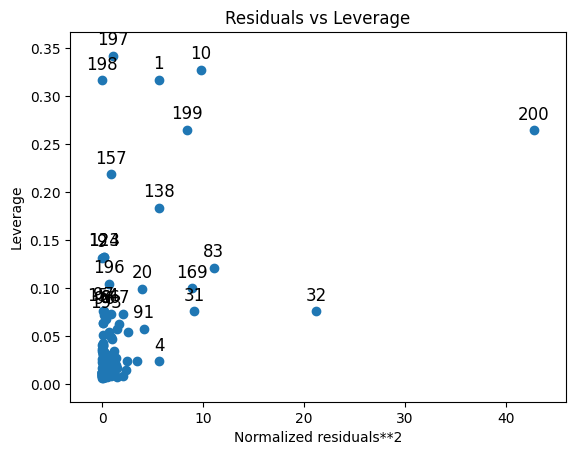

In [12]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


# Split dataset into predictors and response variable
X = cpus_df.iloc[:, :-1]  # All columns except the last one
y = cpus_df.iloc[:, -1]   # The last column is the response variable

# Add a constant column for intercept (required for statsmodels)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Summary of the model
print(model.summary())

# Diagnostic plots
# 1. Residuals vs Fitted
for predictor in X.columns[1:]:  # Skip the constant column
    sm.graphics.plot_fit(model, exog_idx=predictor)
    plt.xlabel(predictor)
    plt.ylabel("Performance")
    plt.title(f"Fitted vs Residuals for {predictor}")
    plt.show()

# 2. Q-Q plot for residuals
sm.graphics.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()

# 3. Residuals vs Leverage
sm.graphics.plot_leverage_resid2(model)
plt.title("Residuals vs Leverage")
plt.show()




## Residuals vs Leverage

The above plot is quite different the the R plot:

<img src="https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/residuals_vs_leverage_in_R.PNG?raw=1" alt="residuals vs levarage plot in R" width="600" height="400">

Note that

- the axes are reversed,
- the standardized residuals are squared in Python and they are not R,
- the Cook's boundaries are included for easier interpretation.

# Scale-Location needs to be simulated, too

<img src="https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/scale_vs_location_in_R.PNG?raw=1" alt="scale vs location plot in R" width="600" height="400">

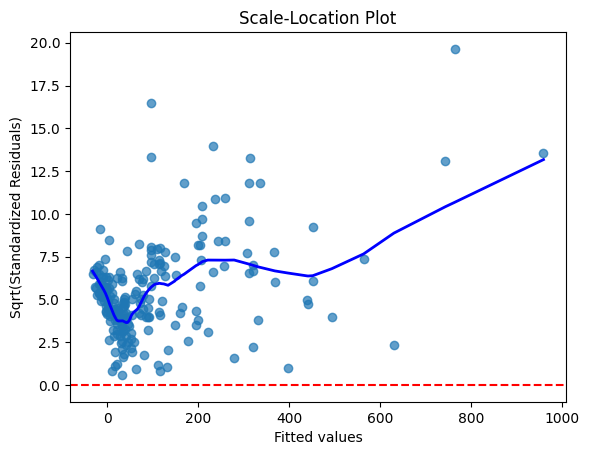

In [16]:
# 4. Scale-Location Plot
residuals = model.resid
fitted = model.fittedvalues
sqrt_std_residuals = np.sqrt(np.abs(residuals))

# Lowess smoothing for trend line
lowess_smooth = lowess(sqrt_std_residuals, fitted, frac=0.3)  # frac controls the smoothing

plt.scatter(fitted, sqrt_std_residuals, alpha=0.7)
plt.axhline(y=0, color="red", linestyle="--")
plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color="blue", linewidth=2, label="Trend Line (Lowess)")

plt.title("Scale-Location Plot")
plt.xlabel("Fitted values")
plt.ylabel("Sqrt(Standardized Residuals)")
plt.show()

